<a href="https://colab.research.google.com/github/butlerbt/SegmentingBuildings/blob/colab/competition_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from PIL import Image as PImage
from fastai.vision import *

In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import glob

In [4]:
from google.colab import drive 
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [5]:
# Download test STAC 
!wget https://drivendata-public-assets.s3.amazonaws.com/test.tgz
# Extract test files
!tar -xvf test.tgz

--2020-01-29 00:13:57--  https://drivendata-public-assets.s3.amazonaws.com/test.tgz
Resolving drivendata-public-assets.s3.amazonaws.com (drivendata-public-assets.s3.amazonaws.com)... 52.216.104.115
Connecting to drivendata-public-assets.s3.amazonaws.com (drivendata-public-assets.s3.amazonaws.com)|52.216.104.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8997646326 (8.4G) [application/x-tar]
Saving to: ‘test.tgz’

test.tgz            100%[===================>]   8.38G  17.0MB/s    in 9m 18s  

2020-01-29 00:23:16 (15.4 MB/s) - ‘test.tgz’ saved [8997646326/8997646326]

test/
test/81fb93/
test/81fb93/81fb93.json
test/81fb93/81fb93.tif
test/dfdc1f/
test/dfdc1f/dfdc1f.tif
test/dfdc1f/dfdc1f.json
test/e29334/
test/e29334/e29334.json
test/e29334/e29334.tif
test/191a51/
test/191a51/191a51.tif
test/191a51/191a51.json
test/933e48/
test/933e48/933e48.json
test/933e48/933e48.tif
test/d795df/
test/d795df/d795df.tif
test/d795df/d795df.json
test/cbefc1/
test/cbefc1/cbef

In [0]:
!rm -rf test.tgz

In [6]:
# Prep list of images
test_ims = glob.glob('test/*/*.tif')
print("Found ", len(test_ims), "images")

test_df = pd.DataFrame({
    'fn':test_ims,
    'id':[t.split('/')[1] for t in test_ims]
})
print(test_df.shape)
test_df.head()

Found  11481 images
(11481, 2)


,fn,id
0,test/38f885/38f885.tif,38f885
1,test/2eaba3/2eaba3.tif,2eaba3
2,test/fc9062/fc9062.tif,fc9062
3,test/67cd4c/67cd4c.tif,67cd4c
4,test/c7fd06/c7fd06.tif,c7fd06


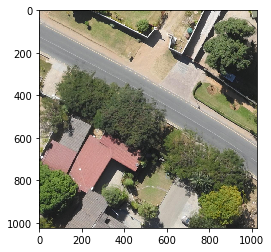

In [10]:

# View a test image
idx = random.choice(range(len(test_df)))
im = PImage.open(test_df.fn.values[idx])
plt.imshow(np.array(im))

In [0]:
!mkdir submission

In [0]:
import pdb

def dice_loss(input, target):
#     pdb.set_trace()
    smooth = 1.
    input = torch.sigmoid(input)
    iflat = input.contiguous().view(-1).float()
    tflat = target.contiguous().view(-1).float()
    intersection = (iflat * tflat).sum()
    return 1 - ((2. * intersection + smooth) / ((iflat + tflat).sum() +smooth))

# adapted from https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/65938
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets.float(), reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'mean': return F_loss.mean()
        elif self.reduction == 'sum': return F_loss.sum()
        else: return F_loss

class DiceLoss(nn.Module):
    def __init__(self, reduction='mean'):
        super().__init__()
        self.reduction = reduction
        
    def forward(self, input, target):
        loss = dice_loss(input, target)
        if self.reduction == 'mean': return loss.mean()
        elif self.reduction == 'sum': return loss.sum()
        else: return loss

class MultiChComboLoss(nn.Module):
    def __init__(self, reduction='mean', loss_funcs=[FocalLoss(),DiceLoss()], loss_wts = [1,1], ch_wts=[1,1,1]):
        super().__init__()
        self.reduction = reduction
        self.ch_wts = ch_wts
        self.loss_wts = loss_wts
        self.loss_funcs = loss_funcs 
        
    def forward(self, output, target):
#         pdb.set_trace()
        for loss_func in self.loss_funcs: loss_func.reduction = self.reduction # need to change reduction on fwd pass for loss calc in learn.get_preds(with_loss=True)
        loss = 0
        channels = output.shape[1]
        assert len(self.ch_wts) == channels
        assert len(self.loss_wts) == len(self.loss_funcs)
        for ch_wt,c in zip(self.ch_wts,range(channels)):
            ch_loss=0
            for loss_wt, loss_func in zip(self.loss_wts,self.loss_funcs): 
                ch_loss+=loss_wt*loss_func(output[:,c,None], target[:,c,None])
            loss+=ch_wt*(ch_loss)
        return loss/sum(self.ch_wts)

  # calculate metrics on one channel (i.e. ch 0 for building footprints only) or on all 3 channels

def acc_thresh_multich(input:Tensor, target:Tensor, thresh:float=0.5, sigmoid:bool=True, one_ch:int=None)->Rank0Tensor:
    "Compute accuracy when `y_pred` and `y_true` are the same size."
    
#     pdb.set_trace()
    if sigmoid: input = input.sigmoid()
    n = input.shape[0]
    
    if one_ch is not None:
        input = input[:,one_ch,None]
        target = target[:,one_ch,None]
    
    input = input.view(n,-1)
    target = target.view(n,-1)
    return ((input>thresh)==target.byte()).float().mean()

def dice_multich(input:Tensor, targs:Tensor, iou:bool=False, one_ch:int=None)->Rank0Tensor:
    "Dice coefficient metric for binary target. If iou=True, returns iou metric, classic for segmentation problems."
#     pdb.set_trace()
    n = targs.shape[0]
    input = input.sigmoid()
    
    if one_ch is not None:
        input = input[:,one_ch,None]
        targs = targs[:,one_ch,None]
    
    input = (input>0.5).view(n,-1).float()
    targs = targs.view(n,-1).float()

    intersect = (input * targs).sum().float()
    union = (input+targs).sum().float()
    if not iou: return (2. * intersect / union if union > 0 else union.new([1.]).squeeze())
    else: return intersect / (union-intersect+1.0)

class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True, convert_mode='RGB')
    
class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

In [49]:
src = (SegmentationItemList.from_df(path='',df=test_df[:5000], cols='fn')) # Did in two batches
learn = load_learner(path='drive/My Drive/seg_building_foots/models/', file = 'acc-665946-focaldice-unfrozen.pkl') # Loads the exported learner from earlier
learn.data.add_test(src, tfms=None, tfm_y=False)
preds, y = learn.get_preds(DatasetType.Test) # Careful with ram - do in batches if needed ()

In [53]:
for i in range(len(test_df)):
  if i%1000 == 0:
    print(i)
  if i < 5000:
    im_id = test_df['id'].values[i]
    pred_arr = np.array((preds[i][0].flatten()<0.5).int().reshape(256, 256)) # Thresh to play with
    pred_im = PImage.fromarray(pred_arr.astype(np.uint8))
    scaled_im = pred_im.resize((1024, 1024), PImage.NEAREST)
    scaled_im.save('submission/'+str(im_id)+'.TIFF', compression='tiff_deflate')

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000


4659


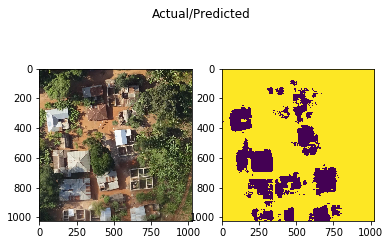

In [56]:
# Examine some outputs
idx = random.choice(range(5000))
print(idx)
img_id = test_df.id.values[idx]
pred_im = PImage.open('submission/'+str(img_id)+'.TIFF')
y_true = PImage.open(test_df.fn.values[idx])

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Actual/Predicted')
ax1.imshow(np.array(y_true))
ax2.imshow(np.array(pred_im))

In [57]:
# Second batch (doing all at once fills RAM)
src = (SegmentationItemList.from_df(path='', df=test_df[5000:], cols='fn')) # Did in two batches
learn = load_learner(path='drive/My Drive/seg_building_foots/models/', file = 'acc-665946-focaldice-unfrozen.pkl') # Loads the exported learner from earlier
learn.data.add_test(src, tfms=None, tfm_y=False)
preds, y = learn.get_preds(DatasetType.Test) # Careful with ram - do in batches if needed ()


In [58]:
for i in range(len(test_df)):
  if i%1000 == 0:
    print(i)
  if i >= 5000:
    im_id = test_df['id'].values[i]
    pred_arr = np.array((preds[i-5000][0].flatten()<0.5).int().reshape(256, 256)) # Thresh to play with
    pred_im = PImage.fromarray(pred_arr.astype(np.uint8))
    scaled_im = pred_im.resize((1024, 1024), PImage.NEAREST)
    scaled_im.save('submission/'+str(im_id)+'.TIFF', compression='tiff_deflate')

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000


9415


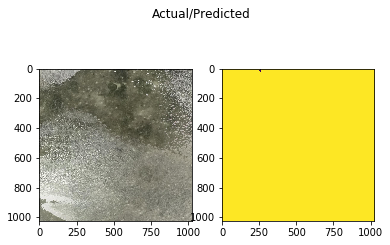

In [60]:
# Examine some outputs
idx = random.choice(range(5000,10000))
print(idx)
img_id = test_df.id.values[idx]
pred_im = PImage.open('submission/'+str(img_id)+'.TIFF')
y_true = PImage.open(test_df.fn.values[idx])

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Actual/Predicted')
ax1.imshow(np.array(y_true))
ax2.imshow(np.array(pred_im))


In [0]:
!cd submission; zip -q -r submission.zip *.TIFF # Add to archive
!cp submission/submission.zip drive/My\ Drive/seg_building_foots/submission.zip # Move to root folder for download

In [0]:
# Check if we missed any test images
import os
missing_files = []
for i in range(len(test_df)):
  im_id = test_df['id'].values[i]
  if not os.path.isfile('submission/'+str(im_id)+'.TIFF'):
    missing_files.append(im_id)
len(missing_files)